# CS6643 Final Project: Pose Estimation and Matching

### Matthew Avallone, Siddharth Choudhary, Kshitija Patel

In [1]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import utils

### Load Images

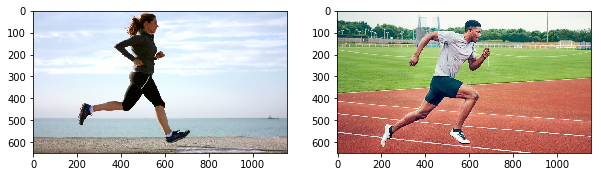

In [2]:
frame1 = cv.imread("running1.jpg") # input
frame2 = cv.imread("running2.jpg") # test

# Ensure images are the same size
hi = min(frame1.shape[0], frame2.shape[0])
wi = min(frame1.shape[1], frame2.shape[1])
frame1 = cv.resize(frame1, (wi,hi))
frame2 = cv.resize(frame2, (wi,hi))

# Visualize images
fig = plt.figure(figsize = (10,20))
plt.subplot(121)
plt.imshow(frame1[:,:,::-1])
plt.subplot(122)
plt.imshow(frame2[:,:,::-1])

In [3]:
frameWidth = frame1.shape[1]
frameHeight = frame1.shape[0]

### The MPII Pose Dataset is annoted with 16 key-points for every human body. 

Hence we initialize a dictionary and 2D array to be able to mark these points on our image and connect them easily 

In [4]:
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
               "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
               ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
               ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]

In [5]:
# A default value set 
inWidth = 300
inHeight = 300

### Load and run the pretrained Pose estimation model on input image 

#### Links to the prototxt and pre-trained model of the MPII Pose dataset:

Prototxt - https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt

Model - http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel

In [6]:
net = cv.dnn.readNetFromCaffe("pose_deploy_linevec_faster_4_stages.prototxt", "pose_iter_160000.caffemodel")
inp = cv.dnn.blobFromImage(frame1, (1.0 / 255), (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
net.setInput(inp)
out = net.forward()

#### The output of the DNN is a 4D array with multiple local maximas for each bodypart. 

We find the global maxima for these local maximas as the location of that body part and form a 2D array of points

In [7]:
print (out.shape)

(1, 44, 38, 38)


In [8]:
pose1 = []
conf1 = []
for i in range(len(BODY_PARTS)):

    heatMap = out[0, i, :, :]
    _, conf, _, point = cv.minMaxLoc(heatMap)
    
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]

    # Add a point if it's confidence is higher than threshold set to 0.1.
    pose1.append((int(x), int(y)) if conf > 0.1 else None)
    conf1.append(conf)

In [9]:
print (pd.DataFrame(pose1, columns=['x','y']))

      x    y
0   516   17
1   486  102
2   455  119
3   364  153
4   455  221
5   486  119
6   486  170
7   547  187
8   455  272
9   547  409
10  607  545
11  455  272
12  395  426
13  243  426
14  486  204
15  151  460


#### Points represent the location the bodyparts

These are marked on the input frame, connect with a line, and labelled using OpenCV functions

In [10]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if pose1[idFrom] and pose1[idTo]:
        cv.line(frame1, pose1[idFrom], pose1[idTo], (255, 74, 0), 3)
        cv.ellipse(frame1, pose1[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.ellipse(frame1, pose1[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.putText(frame1, str(idFrom), pose1[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
        cv.putText(frame1, str(idTo), pose1[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)

### Show output

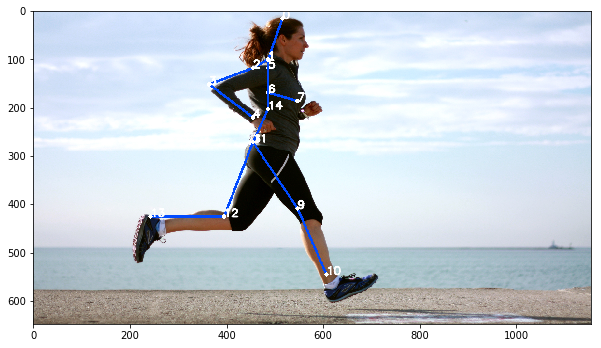

In [11]:
fig1 = plt.figure(figsize = (10,10))
plt.imshow(frame1[:,:,::-1])

### Load and run the pretrained pose estimation model on test image

Run the pose estimation model

In [12]:
inp = cv.dnn.blobFromImage(frame2, (1.0 / 255), (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
net.setInput(inp)
out = net.forward()

Create list of points

In [13]:
pose2 = []
for i in range(len(BODY_PARTS)):

    heatMap = out[0, i, :, :]
    _, conf, _, point = cv.minMaxLoc(heatMap)
    
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]

    pose2.append((int(x), int(y)) if conf > 0.1 else None)

In [14]:
print (pd.DataFrame(pose2, columns=['x','y']))

      x    y
0   638   51
1   547  119
2   486  102
3   395  102
4   334  187
5   607  153
6   577  255
7   638  204
8   455  306
9   607  375
10  516  528
11  455  306
12  364  443
13  243  511
14  486  221
15  699  255


Plot the pose onto the test image

In [15]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if pose2[idFrom] and pose2[idTo]:
        cv.line(frame2, pose2[idFrom], pose2[idTo], (255, 74, 0), 3)
        cv.ellipse(frame2, pose2[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.ellipse(frame2, pose2[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.putText(frame2, str(idFrom), pose2[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
        cv.putText(frame2, str(idTo), pose2[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)

### Show output

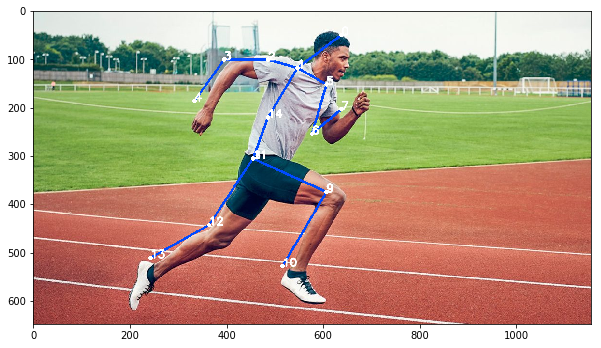

In [16]:
fig2 = plt.figure(figsize = (10,10))
plt.imshow(frame2[:,:,::-1])

### Compare similarity of poses between input and test images

Format the pose vectors into correct format

In [17]:
def similarity_score(pose1, pose2):
    p1 = []
    p2 = []
    pose_1 = np.array(pose1, dtype=np.float)
    pose_2 = np.array(pose2, dtype=np.float)

    # Normalize coordinates
    pose_1[:,0] = pose_1[:,0] / max(pose_1[:,0])
    pose_1[:,1] = pose_1[:,1] / max(pose_1[:,1])
    pose_2[:,0] = pose_2[:,0] / max(pose_2[:,0])
    pose_2[:,1] = pose_2[:,1] / max(pose_2[:,1])

    # L2 Normalization
#     for joint in range(pose_1.shape[0]):
#         mag1 = float(math.sqrt(pose_1[joint][0]**2 + pose_1[joint][1]**2))
#         mag2 = float(math.sqrt(pose_2[joint][0]**2 + pose_2[joint][1]**2))

#         pose_1[joint][0] = pose_1[joint][0] / mag1
#         pose_1[joint][1] = pose_1[joint][1] / mag2
#         pose_2[joint][0] = pose_2[joint][0] / mag2
#         pose_2[joint][1] = pose_2[joint][1] / mag2

    # Turn (16x2) into (32x1)
    for joint in range(pose_1.shape[0]):
        x1 = pose_1[joint][0]
        y1 = pose_1[joint][1]
        x2 = pose_2[joint][0]
        y2 = pose_2[joint][1]

        p1.append(x1)
        p1.append(y1)
        p2.append(x2)
        p2.append(y2)

    p1 = np.array(p1)
    p2 = np.array(p2)

    # Looking to minimize the distance if there is a match
    # Computing two different distance metrics
    scoreA = utils.cosine_distance(p1, p2)
    scoreB = utils.weight_distance(p1, p2, conf1)

    print("Cosine Distance:", scoreA)
    print("Weighted Distance:", scoreB)

#### Compute a distance score between the two pose vectors

In [18]:
similarity_score(pose1, pose2)

Cosine Distance: 0.036548830541884736
Weighted Distance: 0.23758578356644247


#### Visualize Matching

In [19]:
def visualize_output(pose1, pose2, size):
    
    # Initialize blank canvas
    canvas = np.ones(size)

    # Plot points on images
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if pose1[idFrom] and pose1[idTo]:
            cv.line(canvas, pose1[idFrom], pose1[idTo], (0, 255, 0), 3)
            cv.ellipse(canvas, pose1[idFrom], (4, 4), 0, 0, 360, (0, 255, 0), cv.FILLED)
            cv.ellipse(canvas, pose1[idTo], (4, 4), 0, 0, 360, (0, 255, 0), cv.FILLED)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if pose2[idFrom] and pose2[idTo]:
            cv.line(canvas, pose2[idFrom], pose2[idTo], (255, 0, 0), 3)
            cv.ellipse(canvas, pose2[idFrom], (4, 4), 0, 0, 360, (255, 0, 0), cv.FILLED)
            cv.ellipse(canvas, pose2[idTo], (4, 4), 0, 0, 360, (255, 0, 0), cv.FILLED)

    # Visualize images
    fig3 = plt.figure(figsize = (10,10))
    plt.imshow(canvas[:,:,::-1])
    plt.grid(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


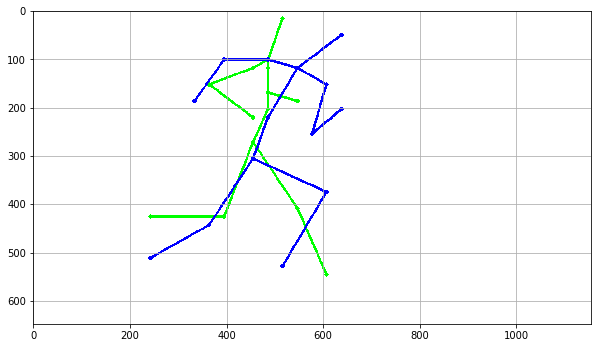

In [20]:
visualize_output(pose1, pose2, frame1.shape)

## Pose Matching with Affine Transformation


Another approach we tried was first finding the affine transformation to match point 1 (neck) and point 14 (the abdomen) to align the centers of the bodies

In [21]:
q = np.array([[pose1[1][0]],[pose1[1][1]],[pose1[14][0]],[pose1[14][1]]], np.float)

p = np.array([[pose2[1][0], pose2[1][1], 1.0, 0.0, 0.0, 0.0], \
              [0.0, 0.0, 0.0, pose2[1][0], pose2[1][1], 1.0], \
              [pose2[14][0], pose2[14][1], 1.0, 0.0, 0.0, 0.0], \
              [0.0, 0.0, 0.0, pose2[14][0], pose2[14][1], 1.0]], np.float)

A, res, rank, s = np.linalg.lstsq(p, q)

T = np.array([[A[0], A[1], A[2]],[A[3], A[4], A[5]],[0.0, 0.0, 1.0]], np.float)

C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Create the new transformed second pose

In [22]:
pose2_new = []

for (i,j) in pose2:
        
        cur_pt = np.array([i,j,1])
        transformed_pt = T.dot(cur_pt)
        
        transformed_pt = transformed_pt / transformed_pt[2]
        pose2_new.append((int(transformed_pt[0]), int(transformed_pt[1])))

#### Compare similarity between the poses

In [23]:
similarity_score(pose1, pose2_new)

Cosine Distance: 0.03375640419056092
Weighted Distance: 0.22549728809323086


#### Visualize the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


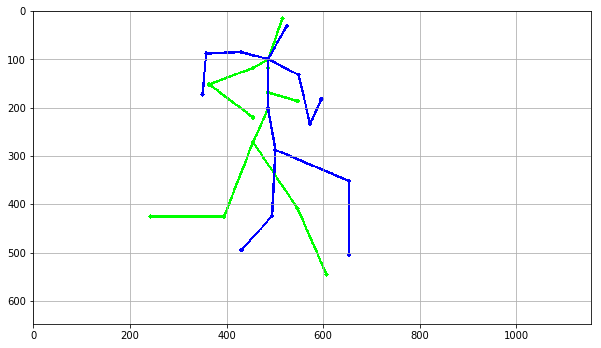

In [24]:
visualize_output(pose1, pose2_new, frame1.shape)

## Pose Matching after Cropping and Scaling

Crop and resize the poses to the same size and then check for similarity

In [25]:
pose1_new = np.array(pose1)
pose2_new = np.array(pose2)

pose1_new[:,0] = pose1_new[:,0] - min(pose1_new[:,0])
pose1_new[:,1] = pose1_new[:,1] - min(pose1_new[:,1])

pose2_new[:,0] = pose2_new[:,0] - min(pose2_new[:,0])
pose2_new[:,1] = pose2_new[:,1] - min(pose2_new[:,1])

In [26]:
resize_x = max(pose2_new[:,0])/max(pose1_new[:,0])
resize_y = max(pose2_new[:,1])/max(pose1_new[:,1])

pose1_new[:,0] = pose1_new[:,0] * resize_x
pose1_new[:,1] = pose1_new[:,1] * resize_y

Compute the new similarity scores

In [27]:
similarity_score (pose1_new, pose2_new)

Cosine Distance: 0.08310575556301181
Weighted Distance: 0.33411498376106713


Visualize the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


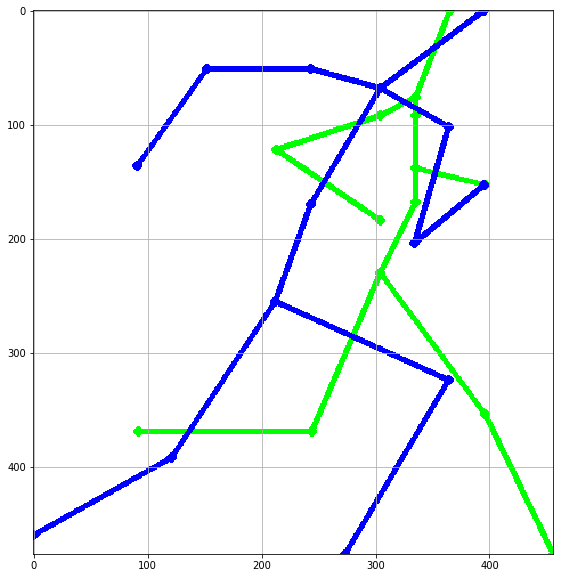

In [28]:
pose1_resized = tuple(map(tuple, pose1_new))
pose2_resized = tuple(map(tuple, pose2_new))

# Get dimensions of output window
pose_1 = np.array(pose1_new)
pose_2 = np.array(pose2_new)
max_y = max(max(pose_1[:,0]), max(pose_2[:,0]))
max_x = max(max(pose_1[:,1]), max(pose_2[:,1]))
dim = (max_x, max_y, 3) 
visualize_output(pose1_resized, pose2_resized, dim)